In [1]:
import os
import sys
import time
nb_dir = os.path.split(os.getcwd())[0]

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

In [2]:
import pandas as pd
from PIL import Image, ImageDraw
import copy

In [3]:
from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services.get_xml import  create_pdf_processing_paths, extract_pdf_metadata, process_input_pdf
from anuvaad_auditor.loghandler import log_info
from anuvaad_auditor.loghandler import log_error
from src.services import main
from src.services.get_underline import get_underline
from services import get_xml
from src.services.child_text_unify_to_parent import ChildTextUnify
from services.preprocess import prepocess_pdf_regions
from services.get_tables import page_num_correction , get_text_table_line_df
from src.services.ocr_text_utilities import  tesseract_ocr
import src.utilities.app_context as app_context
import config

In [4]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

In [5]:
app_context.application_context= dict({'input': {'files': [{'locale': 'hi', 'path': 'RTIOrder_hi.pdf', 'type': 'pdf'}]}, 'jobID': 'BM-15913540488115873', 'state': 'INITIATED', 'status': 'STARTED', 'stepOrder': 0, 'workflowCode': 'abc', 'tool': 'BM', 'metadata': {'module': 'WORKFLOW-MANAGER', 'receivedAt': 15993163946431696, 'sessionID': '4M1qOZj53tIZsCoLNzP0oP', 'userID': 'd4e0b570-b72a-44e5-9110-5fdd54370a9d'}, 'taskID': 'BM-16000776881221366'})

## start of the program

In [14]:
'''
  folder structure of test data goes like this
  - notebooks
      - sample-data
          - input
          - output
          
  the pdfs are present in "input" directory and they are *.pdf is added into .gitignore
  just to save repo size.
'''

base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data','input')
save_dir   = os.path.join(base_dir, 'sample-data', 'bbox_output')
output_dir = os.path.join(base_dir, 'sample-data', 'output')

filename   = '4334_2008_3_1501_15489_Judgement_01-Aug-2019_MAL.pdf'
lang ='hi'
index = 1

## extract the pdf into xml & background images for downstream processing

In [15]:
pdf_filepath      = os.path.join(input_dir, filename)

img_dfs,xml_dfs, page_width, page_height,working_dir, pdf_bg_img_filepaths, pdf_image_paths  = get_xml.process_input_pdf(filename, input_dir, lang)
#img_dfs, xml_dfs, page_width, page_height, working_dir, pdf_bg_img_filepaths = get_xml.process_input_pdf(pdf_filepath, output_dir, 'JOBID_1000')
#header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)


[2020-09-17 12:26:23,774] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/231501000012011_1_e62c1298-f8b2-11ea-8d07-38baf82f7425
[2020-09-17 12:26:23,780] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/231501000012011_1.pdf, working_dir /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/231501000012011_1_e62c1298-f8b2-11ea-8d07-38baf82f7425
[2020-09-17 12:26:24,080] {loghandler.py:20} MainThread INFO in loghandler: Extracting xml of /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/231501000012011_1.pdf
[2020-09-17 12:26:24,223] {loghandler.py:20} MainThread INFO in loghandler: Extracting background images of /home/nare

# Draw Bounding box using dfs

In [16]:
def doc_structure_analysis(xml_dfs,img_dfs,working_dir ,lang, page_width, page_height, pdf_bg_img_filepaths,pdf_image_paths):
    
    '''
        Document structure analysis to get:
            - in_dfs
            - table_dfs
            - line_dfs
            - h_dfs
            - v_dfs
            - p_dfs
            - text_block_dfs

    '''
    log_info("document structure analysis started  ===>", app_context.application_context )

    header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)
    text_merger = ChildTextUnify()
    
    in_dfs, table_dfs, line_dfs,bg_dfs = get_text_table_line_df(xml_dfs, img_dfs, pdf_bg_img_filepaths)
    in_dfs[0]['font_family']="times"
    in_dfs[0]['font_family_updated']="times"
    h_dfs = get_xml.get_hdfs(in_dfs, header_region, footer_region)
    
    if lang != 'en':
        h_dfs = tesseract_ocr(pdf_image_paths, page_width, page_height, h_dfs, lang)
        for h_df in h_dfs:
            h_df['children'] = None
    v_dfs                              = get_xml.get_vdfs(h_dfs)
    p_dfs                              = get_xml.get_pdfs(v_dfs, lang)
    p_dfs , line_dfs                   = get_underline(p_dfs,line_dfs,app_context.application_context)
    
    
    if lang=='en':
        p_dfs  = text_merger.unify_child_text_blocks(p_dfs)
    
    
    log_info( "document structure analysis successfully completed", app_context.application_context )
    return in_dfs,h_dfs, v_dfs, p_dfs

In [17]:
in_dfs,h_dfs, v_dfs, p_dfs = doc_structure_analysis([xml_dfs[index]],[img_dfs[index]],working_dir, lang, page_width, page_height, [pdf_bg_img_filepaths[index]],[pdf_image_paths[index]])

[2020-09-17 12:26:25,074] {loghandler.py:20} MainThread INFO in loghandler: document structure analysis started  ===>
[2020-09-17 12:26:25,167] {loghandler.py:20} MainThread INFO in loghandler: Header Footer detection completed successfully  in time 0.08997297286987305 
[2020-09-17 12:26:25,168] {loghandler.py:20} MainThread INFO in loghandler: Footers found 24 
[2020-09-17 12:26:25,169] {loghandler.py:20} MainThread INFO in loghandler: Headers found 4
[2020-09-17 12:26:25,169] {loghandler.py:20} MainThread INFO in loghandler: TableExtractor service started
[2020-09-17 12:26:25,390] {loghandler.py:20} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.16673898696899414/1, average per page 0.16673898696899414
[2020-09-17 12:26:25,390] {loghandler.py:20} MainThread INFO in loghandler: tesseract ocr started  ===>
[2020-09-17 12:26:33,304] {loghandler.py:20} MainThread INFO in loghandler: tesseract ocr successfully completed in 7.912879705429077/1, average per page 7.9128

/home/naresh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
#when lang='hi+en'
p_df['text'].values

array([' . इन्द्रियों से परे 2. प्रकाश, उजाला',
       ' मैंने हैरान होकर देखा-आसमान जैसे उलटा पड़ा  था और सारे तारे बिखरकर नीचे टिमटिमा रहे थे।  दूर...ढलान लेती तराईं पर सितारों के गुच्छे रोशनियों  की एक झालर-सी बना रहे थे। क्या था वह?  वह रात में जगमगाता गैंगटॉक शहर था-इतिहास  और वर्तमान के संधि-स्थल पर खड़ा मेहनतकश  बादशाहों का वह एक ऐसा शहर था जिसका सब  कुछ सुंदर था-सुबह, शाम, रात।',
       " और वह रहस्यमयी सितारों भरी रात मुझमें  सम्मोहन जगा रही थी, कुछ इस कदर कि उन जादू भरे क्षणों में मेरा सब कुछ स्थगित  था, अर्थहीन था...मैं, मेरी चेतना, मेरा आस-पास। मेरे भीतर-बाहर सिर्फ़ शून्य था और थी  आतींद्रियता' में डूबी रोशनी की वह जादुई झालर।",
       ' धीरे-धीरे एक उजास* उस शून्य से फूटने लगा...एक प्रार्थना होंठों को छूने लगी...  साना-साना हाथ जोड़ि, गदंहु प्रार्थना। हाम्रो जीवन तिम्रो कौसेली (छोटे-छोटे हाथ जोड़कर  प्रार्थना कर रही हूं कि मेरा सारा जीवन अच्छाइयों को समर्पित हो )। आज सुबह को प्रार्थना  के ये बोल मैंने एक नेपाली युवती से सीखे थे।',
       ' सुबह हमें यूमथांग के लिए निकल पड़

In [16]:
#when lang='hi'
p_df['text'].values

array([' ]. डन्द्रया से पर 2. प्रकाश, उजाला',
       ' मन हरान होकर दखा--आसमान ज॑स उलटा पडा  था आर सार तार बिखरकर नाच [टमाटमा रह थ।  दर,,..ढलान लता तराइ पर ।सतारा के गुच्छ राशानयां  का एक झालर-सा बना रह थ। क्या था वह  वह रात मं जगमगाता गंगटाक शहर था-इतिहास  आर वतमान के साध-स्थल पर खडा महनतकश  बादशाहा का वह एक एंसा शहर था [।जसका सब  कछ सुदर था-सबह , शाम, रात।',
       " आर वह रहस्यमया सतारा भरा रात मुझम  सम्मोहन जगा रहा था, कुछ इस कदर कि उन जादू भर क्षणा मं मरा सब कछ स्थागत  था, अथहान था,..म, मरा चंतना, मरा आस-पास। मर भातर-बाहर 'सफ़े शून्य था आर थी  अतीडद्रियता' में डूबी रोशनी को वह जादुई झालर।",
       ' धीरे-धीरे एक उजास” उस शन्य से फटने लगा...एक प्रार्थना होंठों को छने लगी...  साना-साना हाथ जोड़, गदह प्राथना। हाम्रीं जावन ततिम्रा कोसला (छाट-छाोट हाथ जाडकर  प्राथना कर रही ह कि मरा सारा जीवन अच्छाइयां को सर्मापत हो )। आज सृबह का प्राथना  क य॑ बोल मन एक नंपालाी युवता से साख थे।',
       " सुबह हम यमथाग के लए नकल पड़ना था, पर आख खुलत हा म बालकना का  तरफ़ भागो। यहा के लागा न बताया था के य

In [20]:
page_index      = 0
img_filepath    = pdf_image_paths[page_index]

in_df   = in_dfs[page_index]
h_df    = h_dfs[page_index]
v_df    = v_dfs[page_index]
p_df    = p_dfs[page_index]
#ocr_df  = ocr_dfs[page_index]

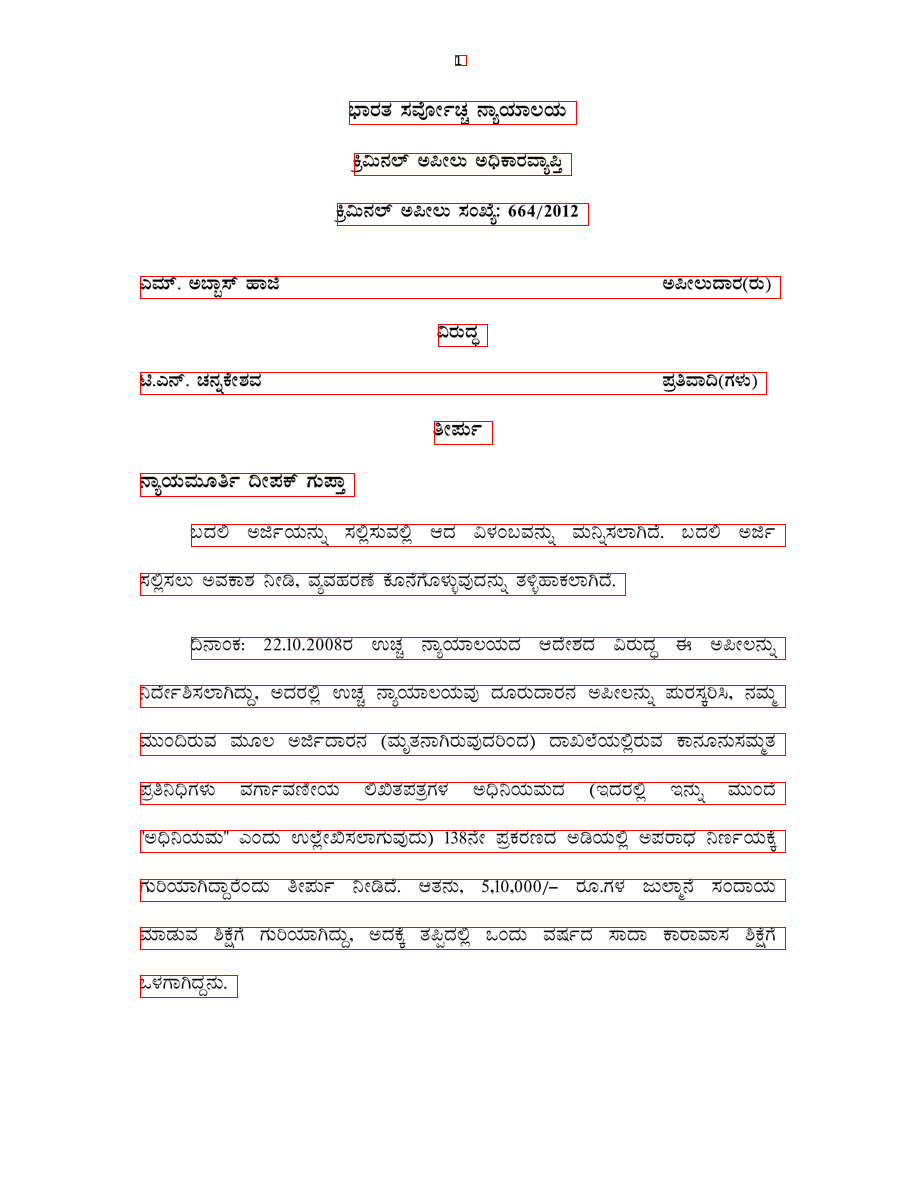

In [19]:
draw_box(img_filepath, page_width, page_height,h_df, color='red')

# Draw bounding box for json response 

In [8]:
from src.services import main

In [9]:
pdf_path = input_dir+"/"+filename
save_path  = save_dir+"/"+str(filename.split('.pdf')[0])
if not os.path.exists(save_path):
    os.system('mkdir -p {0}'.format(save_path))
data = main.DocumentStructure(app_context, filename, lang='hi',base_dir=input_dir)

[2020-09-14 19:15:28,740] {loghandler.py:48} MainThread DEBUG in loghandler: Block merger starting processing {'input': {'files': [{'locale': 'hi', 'path': 'RTIOrder_hi.pdf', 'type': 'pdf'}]}, 'jobID': 'BM-15913540488115873', 'state': 'INITIATED', 'status': 'STARTED', 'stepOrder': 0, 'workflowCode': 'abc', 'tool': 'BM', 'metadata': {'module': 'WORKFLOW-MANAGER', 'receivedAt': 15993163946431696, 'sessionID': '4M1qOZj53tIZsCoLNzP0oP', 'userID': 'd4e0b570-b72a-44e5-9110-5fdd54370a9d'}, 'taskID': 'BM-16000776881221366'}
[2020-09-14 19:15:28,742] {loghandler.py:20} MainThread INFO in loghandler: document preprocessing started ===>
[2020-09-14 19:15:28,743] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/report_001_hi_8cdffdea-f690-11ea-8d07-38baf82f7425
[2020-09-14 19:15:28,744] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/

KeyboardInterrupt: 

In [66]:
response = data['result']

In [67]:
def draw_bbox_image(draw,page_data):
    
    if page_data['images']:
        try:
            for image_block in page_data['images']:
                    top     = image_block["text_top"];         left   = image_block["text_left"];  
                    bottom  = top+image_block["text_height"];  right  = left+image_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='green')
            return draw
        except:
            pass

In [68]:
def draw_bbox_table(draw,page_data):
    
    if page_data['tables']:
        try:
            for table_block in page_data['tables']:
                    top     = table_block["text_top"];         left   = table_block["text_left"];  
                    bottom  = top+table_block["text_height"];  right  = left+table_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='blue')
            return draw
        except:
            pass

In [69]:
def draw_bbox_text(draw,page_data):
    
    if page_data['text_blocks']:
        try:
            for text_block in page_data['text_blocks']:
                top     = text_block["text_top"];         left   = text_block["text_left"];  
                bottom  = top+text_block["text_height"];  right  = left+text_block["text_width"]
                draw.rectangle(((left, top), (right,bottom)), outline='red')
            return draw
        except:
            pass

In [70]:
def draw_bbox_pdf(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        draw  = draw_bbox_text(draw,page_data)
        draw  = draw_bbox_image(draw,page_data)
        draw  = draw_bbox_table(draw,page_data)
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [71]:
draw_bbox_pdf(response,pdf_image_paths,save_path)

# draw word bounding box

In [ ]:
def draw_bbox_word_pdf(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        draw   = draw_bbox_text(draw,page_data)
        draw   = draw_bbox_image(draw,page_data)
        draw   = draw_bbox_table(draw,page_data)
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [ ]:
draw_bbox_word_pdf(response,pdf_image_paths,save_path)